In [1]:
import os
import json
import random
import yaml
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms

from datasets import build_dataset
from datasets.utils import build_data_loader
import clip
# from utils import *

In [2]:
configs_dir = 'C:/Users/anish/Documents/AML/applied-ml/Tip-Adapter/configs'

# Get all YAML files in the directory
yaml_files = [f for f in os.listdir(configs_dir) if f.endswith('.yaml')]

# Dictionary to store all loaded configs
all_configs = {}

for yaml_file in yaml_files:
    config_path = os.path.join(configs_dir, yaml_file)

    assert os.path.exists(config_path), f"Config file not found: {config_path}"
    
    # Load YAML configuration
    cfg = yaml.load(open(config_path, 'r'), Loader=yaml.Loader)

    # Create cache directory based on dataset
    cache_dir = os.path.join('./caches', cfg['dataset'])
    os.makedirs(cache_dir, exist_ok=True)
    cfg['cache_dir'] = cache_dir

    # Store config in dictionary using filename (without extension) as key
    config_key = os.path.splitext(yaml_file)[0]
    all_configs[config_key] = cfg

# Example: Access a specific config later
print(all_configs)  # if the filename was caltech101.yaml


{'caltech101': {'root_path': '', 'load_cache': False, 'load_pre_feat': False, 'search_hp': True, 'search_scale': [12, 5], 'search_step': [200, 20], 'init_beta': 1, 'init_alpha': 3, 'dataset': 'caltech101', 'shots': 16, 'backbone': 'ViT-B/16', 'lr': 0.001, 'augment_epoch': 10, 'train_epoch': 20, 'cache_dir': './caches\\caltech101'}, 'food101': {'root_path': '', 'load_cache': False, 'load_pre_feat': False, 'search_hp': True, 'search_scale': [10, 10], 'search_step': [200, 20], 'init_beta': 1, 'init_alpha': 1.17, 'dataset': 'food101', 'shots': 16, 'backbone': 'ViT-B/16', 'lr': 0.001, 'augment_epoch': 10, 'train_epoch': 20, 'cache_dir': './caches\\food101'}, 'ucf101': {'root_path': '', 'load_cache': False, 'load_pre_feat': False, 'search_hp': True, 'search_scale': [7, 3], 'search_step': [200, 20], 'init_beta': 1, 'init_alpha': 3, 'dataset': 'ucf101', 'shots': 16, 'backbone': 'ViT-B/16', 'lr': 0.001, 'augment_epoch': 10, 'train_epoch': 20, 'cache_dir': './caches\\ucf101'}}


# **FOR CALTECH-101**


In [3]:
def clip_classifier(classnames, template, clip_model, cupl_enable, dataset_name):
    with open(rf"CuPL_prompts/{dataset_name}.json", "r") as f:
        cupl_template = json.load(f)

    with torch.no_grad():
        clip_weights = []

        for classname in classnames:
            # Tokenize the prompts
            classname = classname.replace('_', ' ')
            texts = [t.format(classname) for t in template]
            if cupl_enable is True:
                for txt in cupl_template[classname]:
                    texts.append(txt)
            texts = clip.tokenize(texts).cuda()
            # prompt ensemble for ImageNet
            class_embeddings = clip_model.encode_text(texts)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            clip_weights.append(class_embedding)

        clip_weights = torch.stack(clip_weights, dim=1).cuda()
    return clip_weights

In [4]:
def build_cache_model(cfg, clip_model, train_loader_cache):

    if cfg['load_cache'] == False:    
        cache_keys = []
        cache_values = []

        with torch.no_grad():
            # Data augmentation for the cache model
            for augment_idx in range(cfg['augment_epoch']):
                train_features = []

                print('Augment Epoch: {:} / {:}'.format(augment_idx, cfg['augment_epoch']))

                
                for i, (images, target) in enumerate(tqdm(train_loader_cache)):
                    images = images.cuda()
                    image_features = clip_model.encode_image(images)
                    train_features.append(image_features)
                    if augment_idx == 0:
                        target = target.cuda()
                        cache_values.append(target)
                cache_keys.append(torch.cat(train_features, dim=0).unsqueeze(0))
            
        cache_keys = torch.cat(cache_keys, dim=0).mean(dim=0)
        cache_keys /= cache_keys.norm(dim=-1, keepdim=True)
        cache_keys = cache_keys.permute(1, 0)
        cache_values = F.one_hot(torch.cat(cache_values, dim=0)).half()

        torch.save(cache_keys, cfg['cache_dir'] + '/keys_' + str(cfg['shots']) + "shots.pt")
        torch.save(cache_values, cfg['cache_dir'] + '/values_' + str(cfg['shots']) + "shots.pt")

    else:
        cache_keys = torch.load(cfg['cache_dir'] + '/keys_' + str(cfg['shots']) + "shots.pt")
        cache_values = torch.load(cfg['cache_dir'] + '/values_' + str(cfg['shots']) + "shots.pt")

    return cache_keys, cache_values

In [5]:
def pre_load_features(cfg, split, clip_model, loader):

    if cfg['load_pre_feat'] == False:
        features, labels = [], []

        with torch.no_grad():
            for i, (images, target) in enumerate(tqdm(loader)):
                images, target = images.cuda(), target.cuda()
                image_features = clip_model.encode_image(images)
                image_features /= image_features.norm(dim=-1, keepdim=True)
                features.append(image_features)
                labels.append(target)

        features, labels = torch.cat(features), torch.cat(labels)

        torch.save(features, cfg['cache_dir'] + "/" + split + "_f.pt")
        torch.save(labels, cfg['cache_dir'] + "/" + split + "_l.pt")
   
    else:
        features = torch.load(cfg['cache_dir'] + "/" + split + "_f.pt")
        labels = torch.load(cfg['cache_dir'] + "/" + split + "_l.pt")
    
    return features, labels

In [6]:
all_configs.keys()

dict_keys(['caltech101', 'food101', 'ucf101'])

In [11]:
cfg_results = {}

for c in all_configs:
    cfg = all_configs[c]
    # Load CLIP model
    clip_model, preprocess = clip.load(cfg['backbone'])
    clip_model.eval()

    random.seed(1)
    torch.manual_seed(1)

    # Dataset
    dataset = build_dataset(cfg['dataset'], cfg['root_path'], cfg['shots'])
    val_loader = build_data_loader(dataset.val, batch_size=64, is_train=False, tfm=preprocess, shuffle=False)
    test_loader = build_data_loader(dataset.test, batch_size=64, is_train=False, tfm=preprocess, shuffle=False)

    # Train transforms
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.5, 1), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                             std=(0.26862954, 0.26130258, 0.27577711))
    ])
    train_loader_cache = build_data_loader(dataset.train_x, batch_size=256, tfm=train_transform, is_train=True, shuffle=False)

    # CLIP weights and cache model
    clip_weights = clip_classifier(dataset.classnames, dataset.template, clip_model, cupl_enable=False,dataset_name=c)
    clip_weights_cupl = clip_classifier(dataset.classnames, dataset.template, clip_model, cupl_enable=True,dataset_name=c)

    cache_keys, cache_values = build_cache_model(cfg, clip_model, train_loader_cache)

    # Preload features
    val_features, val_labels = pre_load_features(cfg, "val", clip_model, val_loader)
    test_features, test_labels = pre_load_features(cfg, "test", clip_model, test_loader)

    # Store results for this config
    cfg_results[c] = {
        "clip_weights": clip_weights,
        "clip_weights_cupl": clip_weights_cupl,
        "cache_keys": cache_keys,
        "cache_values": cache_values,
        "val_features": val_features,
        "val_labels": val_labels,
        "test_features": test_features,
        "test_labels": test_labels,
    }


Reading split from Data/caltech-101\split_zhou_Caltech101.json
Creating a 16-shot dataset
Augment Epoch: 0 / 10


100%|██████████| 7/7 [00:33<00:00,  4.85s/it]


Augment Epoch: 1 / 10


100%|██████████| 7/7 [00:31<00:00,  4.56s/it]


Augment Epoch: 2 / 10


100%|██████████| 7/7 [00:32<00:00,  4.65s/it]


Augment Epoch: 3 / 10


100%|██████████| 7/7 [00:31<00:00,  4.49s/it]


Augment Epoch: 4 / 10


100%|██████████| 7/7 [00:30<00:00,  4.36s/it]


Augment Epoch: 5 / 10


100%|██████████| 7/7 [00:31<00:00,  4.43s/it]


Augment Epoch: 6 / 10


100%|██████████| 7/7 [00:31<00:00,  4.44s/it]


Augment Epoch: 7 / 10


100%|██████████| 7/7 [00:30<00:00,  4.41s/it]


Augment Epoch: 8 / 10


100%|██████████| 7/7 [00:31<00:00,  4.48s/it]


Augment Epoch: 9 / 10


100%|██████████| 39/39 [00:33<00:00,  1.18it/s]


Reading split from Data/food-101\split_zhou_Food101.json


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000019F3E37FC70>
Traceback (most recent call last):
  File "C:\Users\anish\AppData\Roaming\Python\Python310\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\anish\AppData\Roaming\Python\Python310\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Creating a 16-shot dataset
Augment Epoch: 0 / 10


100%|██████████| 7/7 [00:34<00:00,  4.94s/it]


Augment Epoch: 1 / 10


100%|██████████| 7/7 [00:32<00:00,  4.71s/it]


Augment Epoch: 2 / 10


100%|██████████| 7/7 [00:32<00:00,  4.65s/it]


Augment Epoch: 3 / 10


100%|██████████| 7/7 [00:32<00:00,  4.66s/it]


Augment Epoch: 4 / 10


100%|██████████| 7/7 [00:46<00:00,  6.61s/it]


Augment Epoch: 5 / 10


100%|██████████| 7/7 [00:33<00:00,  4.74s/it]


Augment Epoch: 6 / 10


100%|██████████| 7/7 [00:32<00:00,  4.63s/it]


Augment Epoch: 7 / 10


100%|██████████| 7/7 [00:32<00:00,  4.66s/it]


Augment Epoch: 8 / 10


100%|██████████| 7/7 [00:32<00:00,  4.68s/it]


Augment Epoch: 9 / 10


100%|██████████| 474/474 [01:49<00:00,  4.31it/s]


Reading split from Data/ucf101\split_zhou_UCF101.json
Creating a 16-shot dataset
Augment Epoch: 0 / 10


100%|██████████| 7/7 [00:36<00:00,  5.15s/it]


Augment Epoch: 1 / 10


100%|██████████| 7/7 [00:32<00:00,  4.58s/it]


Augment Epoch: 2 / 10


100%|██████████| 7/7 [00:33<00:00,  4.84s/it]


Augment Epoch: 3 / 10


100%|██████████| 7/7 [00:31<00:00,  4.45s/it]


Augment Epoch: 4 / 10


100%|██████████| 7/7 [00:32<00:00,  4.66s/it]


Augment Epoch: 5 / 10


100%|██████████| 7/7 [00:32<00:00,  4.67s/it]


Augment Epoch: 6 / 10


100%|██████████| 7/7 [00:33<00:00,  4.83s/it]


Augment Epoch: 7 / 10


100%|██████████| 7/7 [00:34<00:00,  4.87s/it]


Augment Epoch: 8 / 10


100%|██████████| 7/7 [00:34<00:00,  4.93s/it]


Augment Epoch: 9 / 10


100%|██████████| 60/60 [00:40<00:00,  1.48it/s]


In [18]:
cfg_results['caltech101'].keys()

dict_keys(['clip_weights', 'clip_weights_cupl', 'cache_keys', 'cache_values', 'val_features', 'val_labels', 'test_features', 'test_labels'])

**Class Accuracy Function**

In [16]:
def cls_acc(output, target, topk=1):
    pred = output.topk(topk, 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    acc = float(correct[: topk].reshape(-1).float().sum(0, keepdim=True).cpu().numpy())
    acc = 100 * acc / target.shape[0]
    return acc

In [68]:
allacc = {}
for val in cfg_results:

    vals = cfg_results[val]
    cfg = all_configs[val]

    adapter=None
    beta_list = [i * (cfg['search_scale'][0] - 0.1) / cfg['search_step'][0] + 0.1 for i in range(cfg['search_step'][0])]
    alpha_list = [i * (cfg['search_scale'][1] - 0.1) / cfg['search_step'][1] + 0.1 for i in range(cfg['search_step'][1])]

    best_acc = 0
    best_beta, best_alpha = 0, 0

    for beta in beta_list:
        for alpha in alpha_list:
            if adapter:
                affinity = adapter(vals['val_features'])
            else:
                affinity = vals['val_features'] @ vals['cache_keys']

            cache_logits = ((-1) * (beta - beta * affinity)).exp() @ vals['cache_values']
            clip_logits_cupl = 100. * vals['val_features'] @ vals['clip_weights_cupl']
            tip_logits = clip_logits_cupl + cache_logits * alpha
            acc = cls_acc(tip_logits, vals['val_labels'])
        
            if acc > best_acc:
                best_acc = acc
                best_beta = beta
                best_alpha = alpha

    print(val+"\nAfter searching, the best accuarcy: {:.2f}.\n".format(best_acc))


    #Test CLIP accuracy without CuPL
    clip_logits_test = 100. * vals['test_features'] @ vals['clip_weights']
    test_clip_acc = cls_acc(clip_logits_test, vals['test_labels'])
    print(val+"\n**** Zero-shot CLIP's test accuracy: {:.2f}. ****\n".format(test_clip_acc))   


    clip_logits_test_cupl = 100. * vals['test_features'] @ vals['clip_weights_cupl']
    test_clip_acc_cupl = cls_acc(clip_logits_test_cupl, vals['test_labels'])
    print("\n**** Zero-shot CLIP's test accuracy: {:.2f}. ****\n".format(test_clip_acc_cupl))   


    affinity_test = vals['test_features'] @ vals['cache_keys']
    cache_logits_test = ((-1) * (best_beta - best_beta * affinity_test)).exp() @ vals['cache_values']
    tip_logits_test = clip_logits_test + cache_logits_test * best_alpha
    test_tip_acc = cls_acc(tip_logits_test, vals['test_labels'])
    print("**** Tip-Adapter's test accuracy: {:.2f}. ****\n".format(test_tip_acc))


    affinity_test = vals['test_features'] @ vals['cache_keys']
    cache_logits_test = ((-1) * (best_beta - best_beta * affinity_test)).exp() @ vals['cache_values']
    tip_logits_test_cupl = clip_logits_test_cupl + cache_logits_test * best_alpha
    test_tip_acc_cupl = cls_acc(tip_logits_test_cupl, vals['test_labels'])
    print("**** Tip-Adapter's test accuracy: {:.2f}. ****\n".format(test_tip_acc_cupl))

    allacc[val] = {
        'test_clip_acc': round(test_clip_acc,2),
        'test_clip_acc_cupl' : round(test_clip_acc_cupl,2),
        'test_tip_acc': round(test_tip_acc,2),
        'test_tip_acc_cupl': round(test_tip_acc_cupl,2)
    }

C:\Users\anish\AppData\Local\Temp\ipykernel_5088\395259161.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  acc = float(correct[: topk].reshape(-1).float().sum(0, keepdim=True).cpu().numpy())


caltech101
After searching, the best accuarcy: 96.42.

caltech101
**** Zero-shot CLIP's test accuracy: 87.67. ****


**** Zero-shot CLIP's test accuracy: 94.32. ****

**** Tip-Adapter's test accuracy: 94.60. ****

**** Tip-Adapter's test accuracy: 95.38. ****

food101
After searching, the best accuarcy: 86.58.

food101
**** Zero-shot CLIP's test accuracy: 85.86. ****


**** Zero-shot CLIP's test accuracy: 86.10. ****

**** Tip-Adapter's test accuracy: 86.31. ****

**** Tip-Adapter's test accuracy: 86.49. ****

ucf101
After searching, the best accuarcy: 83.67.

ucf101
**** Zero-shot CLIP's test accuracy: 67.59. ****


**** Zero-shot CLIP's test accuracy: 70.39. ****

**** Tip-Adapter's test accuracy: 78.59. ****

**** Tip-Adapter's test accuracy: 80.23. ****



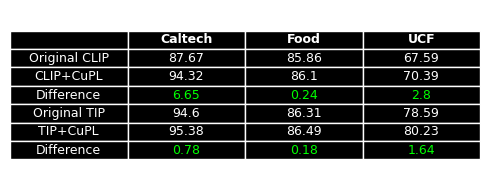

In [73]:
import matplotlib.pyplot as plt
import pandas as pd


# Create DataFrame
datasets = list(allacc.keys())
clip_orig = [allacc[d]['test_clip_acc'] for d in datasets]
clip_cupl = [allacc[d]['test_clip_acc_cupl'] for d in datasets]
clip_change = [round(cupl - orig, 2) for orig, cupl in zip(clip_orig, clip_cupl)]

tip_orig = [allacc[d]['test_tip_acc'] for d in datasets]
tip_cupl = [allacc[d]['test_tip_acc_cupl'] for d in datasets]
tip_change = [round(cupl - orig, 2) for orig, cupl in zip(tip_orig, tip_cupl)]

data = pd.DataFrame({
    '': ['Original CLIP', 'CLIP+CuPL', 'Difference', 'Original TIP','TIP+CuPL', 'Difference'],
    'Caltech': [clip_orig[0], clip_cupl[0], clip_change[0], tip_orig[0], tip_cupl[0], tip_change[0]],
    'Food':    [clip_orig[1], clip_cupl[1], clip_change[1], tip_orig[1], tip_cupl[1], tip_change[1]],
    'UCF':     [clip_orig[2], clip_cupl[2], clip_change[2], tip_orig[2], tip_cupl[2], tip_change[2]]
})

# Display table using matplotlib
fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('off')
table = ax.table(cellText=data.values, colLabels=data.columns, loc='center', cellLoc='center')

# Style all cells: black background, white text & white borders
for i in range(len(data)):
    for j in range(len(data.columns)):
        cell = table[i + 1, j]
        cell.set_facecolor('black')
        cell.get_text().set_color('white')
        cell.set_edgecolor('white')  # <-- white border
        cell.set_text_props(ha='center', va='center')

# Style header
for j in range(len(data.columns)):
    cell = table[0, j]
    cell.set_facecolor('black')
    cell.set_edgecolor('white')  # <-- white border for header
    cell.set_text_props(weight='bold', color='white', ha='center', va='center')

# Highlight positive/negative differences in green/red text
diff_rows = [2, 5]
for row in diff_rows:
    for col_idx, col_name in enumerate(['Caltech', 'Food', 'UCF']):
        val = data.loc[row, col_name]
        text_color = 'lime' if val > 0 else ('red' if val < 0 else 'white')
        table[row + 1, col_idx + 1].get_text().set_color(text_color)

plt.tight_layout()
plt.show()



Top prompts ranked by Tip-Adapter similarity:
1. A airplane is a large metal object that has wings and engines. — 0.2838
2. A plane is a metal, winged machine that is used for transportation. — 0.2609
3. An airplane primarily consists of wings, a fuselage, and an empennage. — 0.2555
4. A modern airplane typically has either a tube-shaped fuselage or a pod-like fuselage, wings, one or more engines, landing gear, and a tail. — 0.2434
5. An airplane looks like a small, metal, bird-like object with two large metal wings. — 0.2407
6. An airplane typically has two wings and a tail. — 0.2383
7. A airplane is a large metal object that has wings and can fly. — 0.2379
8. Aeroplanes typically have wings and engines. — 0.2289
9. A airplane is a long, narrow object with wings. — 0.2253
10. In the photo, an airplane is seen flying in the sky. — 0.2223


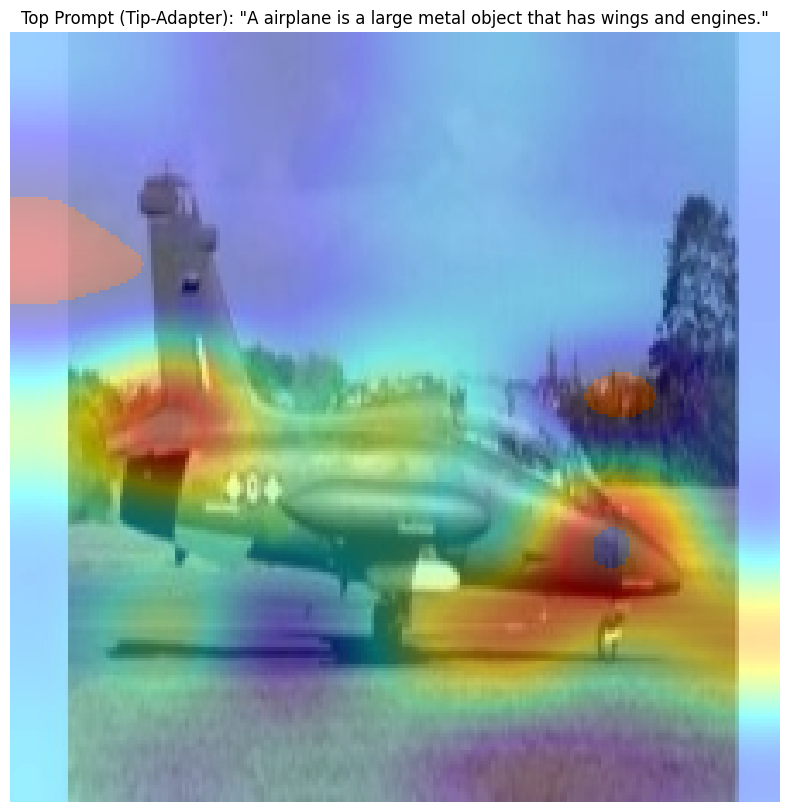

In [74]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import json
import torch.nn.functional as F

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load image
image_path = "Data/caltech-101/101_ObjectCategories/airplanes/image_0001.jpg"
image = Image.open(image_path).convert("RGB")
image_input = preprocess(image).unsqueeze(0).to(device)

# Load prompts from JSON
with open("CuPL_prompts/caltech101.json", "r") as f:
    prompt_data = json.load(f)

class_name = "airplane"
text_prompts = prompt_data.get(class_name, [f"A photo of a {class_name}"])
if not isinstance(text_prompts, list):
    text_prompts = [text_prompts]

# Encode prompts
BATCH_SIZE = 64
text_features = []
with torch.no_grad():
    for i in range(0, len(text_prompts), BATCH_SIZE):
        batch = clip.tokenize(text_prompts[i:i + BATCH_SIZE]).to(device)
        feats = model.encode_text(batch)
        feats = F.normalize(feats, dim=-1)
        text_features.append(feats)
text_features = torch.cat(text_features, dim=0)  # [num_prompts, 512]

# Extract patch tokens from image
with torch.no_grad():
    x = image_input.type(model.visual.conv1.weight.dtype)
    x = model.visual.conv1(x)
    x = x.reshape(1, 768, -1).permute(0, 2, 1)
    cls_token = model.visual.class_embedding.to(x.dtype).expand(x.shape[0], 1, -1)
    x = torch.cat([cls_token, x], dim=1)
    x = x + model.visual.positional_embedding.to(x.dtype)
    x = model.visual.ln_pre(x)
    for blk in model.visual.transformer.resblocks:
        x = blk(x)
    x = model.visual.ln_post(x)
    patch_tokens = x[:, 1:, :].squeeze(0)  # [49, 768]

# Dtype alignment
model_dtype = model.visual.conv1.weight.dtype
patch_tokens = patch_tokens.to(model_dtype)
text_features = text_features.to(model_dtype)

# Project prompts to visual space
if model.visual.proj is not None:
    text_features_proj = text_features @ model.visual.proj.T
else:
    text_features_proj = text_features

# === FAKE cache data (replace with real cache later) ===
N_cache = 30
num_prompts = len(text_prompts)
cache_keys = torch.randn(N_cache, 512).to(device)
cache_values = torch.randn(N_cache, num_prompts).to(device)

# Project and normalize
cache_keys = cache_keys.to(model_dtype)
if model.visual.proj is not None:
    cache_keys = cache_keys @ model.visual.proj.T

# Convert everything to float and normalize
patch_tokens = F.normalize(patch_tokens.float(), dim=-1)
text_features_proj = F.normalize(text_features_proj.float(), dim=-1)
cache_keys = F.normalize(cache_keys.float(), dim=-1)
cache_values = F.normalize(cache_values.float(), dim=-1)



# === CLIP logits ===
clip_logits = patch_tokens @ text_features_proj.T  # [49, num_prompts]

# === Tip-Adapter logic with safe beta-exp ===
affinity = patch_tokens @ cache_keys.T  # [49, N_cache]
affinity = affinity.clamp(min=-1.0, max=1.0)
scaled_affinity = (-1) * (best_beta - best_beta * affinity)
cache_logits = scaled_affinity.exp() @ cache_values  # [49, num_prompts]

# Combine
tip_logits = clip_logits + best_alpha * cache_logits  # [49, num_prompts]

# === Ranking prompts ===
avg_sim = tip_logits.mean(dim=0)  # [num_prompts]
avg_sim_np = avg_sim.detach().cpu().numpy()
ranked = sorted(zip(text_prompts, avg_sim_np), key=lambda x: x[1], reverse=True)

print("\nTop prompts ranked by Tip-Adapter similarity:")
for i, (p, s) in enumerate(ranked[:10]):
    print(f"{i+1}. {p} — {s:.4f}")

# === Generate heatmap ===
top_index = avg_sim.argmax()
top_text_feat = text_features_proj[top_index]
top_text_feat = F.normalize(top_text_feat, dim=-1)
tip_heatmap = (patch_tokens @ top_text_feat).detach().cpu().numpy()
tip_heatmap = (tip_heatmap - tip_heatmap.min()) / (tip_heatmap.max() - tip_heatmap.min() + 1e-6)

tip_heatmap = tip_heatmap.reshape(7, 7).astype(np.float32)
heatmap_resized = cv2.resize(tip_heatmap, (224, 224), interpolation=cv2.INTER_CUBIC)
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
image_resized = cv2.resize(np.array(image), (224, 224))
overlay = cv2.addWeighted(image_resized, 0.6, heatmap_color, 0.4, 0)

# === Plot heatmap overlay ===
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(overlay)
ax.axis("off")
plt.title(f"Top Prompt (Tip-Adapter): \"{text_prompts[top_index]}\"")



plt.show()


In [ ]:
# === Get top prompt from Tip-Adapter ===
avg_sim_tip = tip_logits.mean(dim=0)
top_index = avg_sim_tip.argmax()
top_text_feat = text_features_proj[top_index]
top_text_feat = F.normalize(top_text_feat, dim=-1)
top_prompt = text_prompts[top_index]

# === Compute heatmaps for the same prompt ===
# CLIP-only similarity
clip_sim = patch_tokens @ top_text_feat

# Tip-Adapter-enhanced similarity
affinity = patch_tokens @ cache_keys.T
# affinity = affinity.clamp(min=-1.0, max=1.0)
scaled_affinity = (-1) * (best_beta - best_beta * affinity)
cache_logits = scaled_affinity.exp() @ cache_values
tip_sim = (patch_tokens @ top_text_feat) + best_alpha * cache_logits[:, top_index]

# === Normalize heatmaps ===
def normalize_heatmap(sim):
    sim = sim.detach().cpu().numpy()
    sim = (sim - sim.min()) / (sim.max() - sim.min() + 1e-6)
    return sim.reshape(7, 7).astype(np.float32)

heatmap_clip = normalize_heatmap(clip_sim)
heatmap_tip = normalize_heatmap(tip_sim)

# === Overlay heatmap on original image ===
def overlay_heatmap(heatmap, original_image):
    heatmap_resized = cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_CUBIC)
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    image_resized = cv2.resize(np.array(original_image), (224, 224))
    return cv2.addWeighted(image_resized, 0.6, heatmap_color, 0.4, 0)

overlay_clip = overlay_heatmap(heatmap_clip, image)
overlay_tip = overlay_heatmap(heatmap_tip, image)

# === Plot both heatmaps side-by-side ===
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
axs[0].imshow(overlay_clip)
axs[0].axis("off")
axs[0].set_title(f"CLIP Heatmap\n\"{top_prompt}\"", fontsize=14)

axs[1].imshow(overlay_tip)
axs[1].axis("off")
axs[1].set_title(f"Tip-Adapter Heatmap\n\"{top_prompt}\"", fontsize=14)

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=1)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cb.set_label("Cosine Similarity", fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch.nn.functional as F

def visualize_clip_vs_tip(image: Image.Image,
                          patch_tokens: torch.Tensor,
                          text_feature_proj: torch.Tensor,
                          cache_keys: torch.Tensor,
                          cache_values: torch.Tensor,
                          best_alpha: float,
                          best_beta: float,
                          prompt: str,
                          title: str = "CLIP vs Tip-Adapter Heatmap Comparison"):

    # Normalize text feature
    text_feature = F.normalize(text_feature_proj, dim=-1)

    # Compute CLIP similarity
    sim_clip = patch_tokens @ text_feature

    # Compute Tip-Adapter affinity and cache logits
    affinity = patch_tokens @ cache_keys.T
    # affinity = affinity.clamp(min=-1.0, max=1.0)
    scaled_affinity = (-1) * (best_beta - best_beta * affinity)
    cache_logits = scaled_affinity.exp() @ cache_values  # [49, num_prompts]

    sim_tip = sim_clip + best_alpha * cache_logits[:, 0]

    def to_heatmap(similarity):
        sim = similarity.detach().cpu().numpy()
        sim = (sim - sim.min()) / (sim.max() - sim.min() + 1e-6)
        return sim.reshape(7, 7).astype(np.float32)

    heatmap_clip = to_heatmap(sim_clip)
    heatmap_tip = to_heatmap(sim_tip)
    heatmap_diff = np.clip(heatmap_tip - heatmap_clip, 0, 1)

    def overlay_heatmap(heatmap):
        heatmap_resized = cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_CUBIC)
        heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        image_resized = cv2.resize(np.array(image), (224, 224))
        return cv2.addWeighted(image_resized, 0.6, heatmap_color, 0.4, 0)

    overlays = [overlay_heatmap(h) for h in [heatmap_clip, heatmap_tip, heatmap_diff]]

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(20, 7))
    titles = ['CLIP Heatmap', 'Tip-Adapter Heatmap', 'Difference (Tip - CLIP)']
    for ax, img, t in zip(axs, overlays, titles):
        ax.imshow(img)
        ax.set_title(t, fontsize=14)
        ax.axis('off')
    
    fig.suptitle(f"{title}\nPrompt: '{prompt}'", fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_clip_vs_tip(
    image=image,
    patch_tokens=patch_tokens,
    text_feature_proj=top_text_feat,
    cache_keys=cache_keys,
    cache_values=cache_values,
    best_alpha=best_alpha,
    best_beta=best_beta,
    prompt=text_prompts[top_index] )